In [15]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import re
import time
import sys
import os
from tqdm import tqdm_notebook as tqdm
import sqlite3
import math

from sqlalchemy import create_engine
from collections import Counter

import datetime as dt

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import log_loss
from sklearn.model_selection import cross_val_score

from scipy.sparse import hstack, vstack

from xgboost.sklearn import XGBClassifier

from gensim.models import Word2Vec

import seaborn as sns

# 1. models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.

In [16]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv")
    dfnlp = dfnlp.drop(['qid1','qid2'],axis=1)
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv")
    dfppro = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")
    

#Combining both basic features and nlp features to create final dataset.
final_df = pd.DataFrame(np.hstack([dfnlp, dfppro]), columns= ['id', 'question1', 'question2', 'is_duplicate', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio', 'id', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       'freq_q1-q2'])

print(final_df.shape)

(404290, 31)


In [17]:
#Checking for null Values
nan_rows = final_df[final_df.isnull().any(1)]
print (nan_rows)

            id                                          question1  \
3306      3306                                                NaN   
13016    13016                                                NaN   
20072    20072                            how could i solve this    
20794    20794                                                NaN   
47056    47056  is there anywhere in the world offering pain m...   
96725    96725                                                NaN   
104101  104101                                                NaN   
105780  105780                     how can i develop android app    
134403  134403                                                NaN   
189659  189659                                                NaN   
190570  190570                                                NaN   
201841  201841                   how can i create an android app    
208485  208485                                                NaN   
213220  213220                    

In [18]:
#filling '' for null values
final_df = final_df.fillna('')
nan_rows = final_df[final_df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, question1, question2, is_duplicate, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, id, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []

[0 rows x 31 columns]


In [19]:
#Selecting only 100k points.

final_df_100k = final_df[['question1', 'question2', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min',
                         'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
                         'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 
                         'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total',
                         'word_share', 'freq_q1+q2', 'freq_q1-q2']].sample(n=100000)

x = final_df_100k.drop(['is_duplicate'], axis=1)
y = final_df_100k['is_duplicate']

x_train_temp, x_test_temp, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3)

print("Number of data points in train data :",x_train_temp.shape)
print("Number of data points in test data :",x_test_temp.shape)

Number of data points in train data : (70000, 28)
Number of data points in test data : (30000, 28)


In [20]:
tfidf_q1 = TfidfVectorizer(lowercase=False, min_df=5)

tfidf_train_q1 = tfidf_q1.fit_transform(x_train_temp['question1'])
tfidf_test_q1 = tfidf_q1.transform(x_test_temp['question1'])

tfidf_q2 = TfidfVectorizer(lowercase=False, min_df=5)

tfidf_train_q2 = tfidf_q2.fit_transform(x_train_temp['question2'])
tfidf_test_q2 = tfidf_q2.transform(x_test_temp['question2'])

print(tfidf_train_q1.shape)
print(tfidf_train_q2.shape)
print(tfidf_test_q1.shape)
print(tfidf_test_q2.shape)

(70000, 8524)
(70000, 8375)
(30000, 8524)
(30000, 8375)


In [136]:
#combining all the columns[nlp_features, basic features, tfidf_vec] to create final train and test dataset.

#removing 'question1' and 'question2' column from dataset.
x_train_temp.drop(['question1', 'question2'], axis=1, inplace=True)
x_test_temp.drop(['question1', 'question2'], axis=1, inplace=True)

#stacking tfidf vectors of question1 and question2
train_tfidf = hstack([tfidf_train_q1, tfidf_train_q2])
test_tfidf = hstack([tfidf_test_q1, tfidf_test_q2])

#finally combining/stcking nlp+basic+tfidf features
x_train_nlp_ppro_arr = x_train_temp.to_numpy()
x_test_nlp_ppro_arr = x_test_temp.to_numpy()

X_train = hstack([x_train_nlp_ppro_arr, train_tfidf])
X_test = hstack([x_test_nlp_ppro_arr, test_tfidf])

print(X_train.shape)
print(X_test.shape)

(70000, 16870)
(30000, 16870)


In [137]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6297428571428572 Class 1:  0.37025714285714284
---------- Distribution of output variable in test data ----------
Class 0:  0.3702666666666667 Class 1:  0.3702666666666667


In [33]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# 1.1. Logistic Regression with TF-IDF Vectorizer.

For values of alpha =  1e-05 The log loss is: 0.45631369689385554
For values of alpha =  0.0001 The log loss is: 0.4613069885883901
For values of alpha =  0.001 The log loss is: 0.46046476478615367
For values of alpha =  0.01 The log loss is: 0.4578037046622141
For values of alpha =  0.1 The log loss is: 0.46545724833506874
For values of alpha =  1 The log loss is: 0.4964168255111216
For values of alpha =  10 The log loss is: 0.5351901688289536


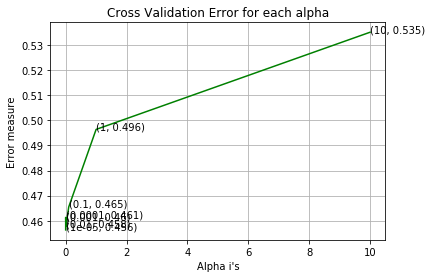

For values of best alpha =  1e-05 The train log loss is: 0.4499641360182757
For values of best alpha =  1e-05 The test log loss is: 0.45631369689385554
Total number of data points : 30000


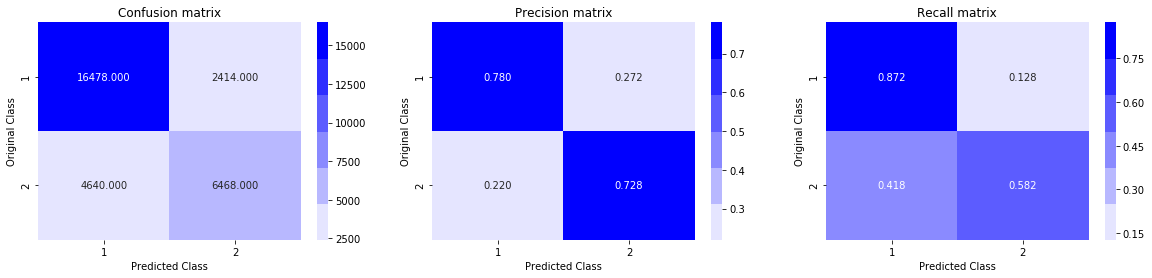

In [139]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, class_weight = "balanced")
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, class_weight = "balanced")
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 1.2. Linear SVM with TF-IDF Vectorizer.¶

For values of alpha =  1e-05 The log loss is: 0.47994959769394574
For values of alpha =  0.0001 The log loss is: 0.49542447070996143
For values of alpha =  0.001 The log loss is: 0.5120678721750362
For values of alpha =  0.01 The log loss is: 0.5174736640254307
For values of alpha =  0.1 The log loss is: 0.507214282075017
For values of alpha =  1 The log loss is: 0.5923965775943995
For values of alpha =  10 The log loss is: 0.6291623157360047


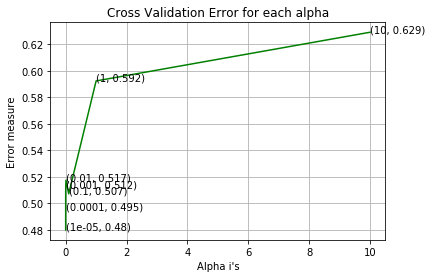

For values of best alpha =  1e-05 The train log loss is: 0.4734663444967557
For values of best alpha =  1e-05 The test log loss is: 0.47994959769394574
Total number of data points : 30000


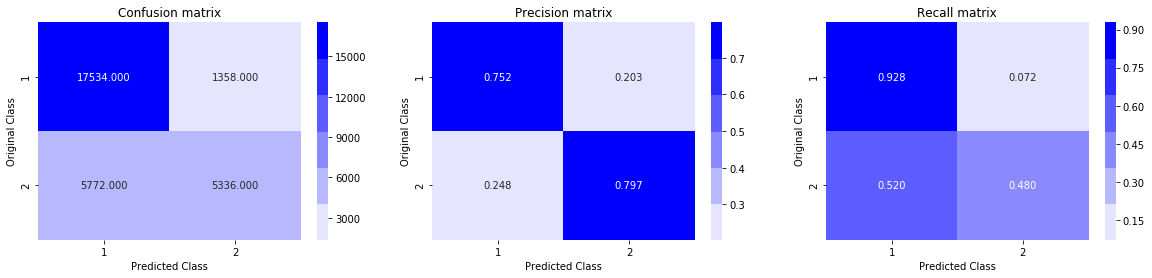

In [140]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# 2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.

In [21]:
def tfidf_w2v(list_of_sent, w2v_model, w2v_words, tfidf_feat, dictionary) :
    row=0;
    tfidf_sent_vectors=[]
    for sent in tqdm(list_of_sent): # for each review/sentence 
        sent_vec = np.zeros(300) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    return pd.DataFrame(tfidf_sent_vectors)

In [22]:
'''Using TF-IDF Model which is already created above.'''

train_q1_list_of_sent=[]
train_q2_list_of_sent=[]
test_q1_list_of_sent=[]
test_q2_list_of_sent=[]

for sent in x_train_temp['question1'].values.astype('U'):
    train_q1_list_of_sent.append(sent.split())
    
for sent in x_train_temp['question2'].values.astype('U'):
    train_q2_list_of_sent.append(sent.split())

for sent in x_test_temp['question1'].values.astype('U'):
    test_q1_list_of_sent.append(sent.split())

for sent in x_test_temp['question2'].values.astype('U'):
    test_q2_list_of_sent.append(sent.split())

w2v_q1_model=Word2Vec(train_q1_list_of_sent, min_count=5, size=300, workers=2)
w2v_q2_model=Word2Vec(train_q2_list_of_sent, min_count=5, size=300, workers=2)

w2v_q1_words = list(w2v_q1_model.wv.vocab)
w2v_q2_words = list(w2v_q1_model.wv.vocab)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_q1 = dict(zip(tfidf_q1.get_feature_names(), list(tfidf_q1.idf_)))
dictionary_q2 = dict(zip(tfidf_q2.get_feature_names(), list(tfidf_q2.idf_)))

print("TFIDF W2V for Train Q1")
tfidfw2v_train_q1 = tfidf_w2v(train_q1_list_of_sent, w2v_q1_model, w2v_q1_words, tfidf_q1.get_feature_names(), dictionary_q1)
print("TFIDF W2V for Train Q2")
tfidfw2v_train_q2 = tfidf_w2v(train_q2_list_of_sent, w2v_q2_model, w2v_q2_words, tfidf_q2.get_feature_names(), dictionary_q2)
print("TFIDF W2V for Test Q1")
tfidfw2v_test_q1 = tfidf_w2v(test_q1_list_of_sent, w2v_q1_model, w2v_q1_words, tfidf_q1.get_feature_names(), dictionary_q1)
print("TFIDF W2V for Test Q2")
tfidfw2v_test_q2 = tfidf_w2v(test_q2_list_of_sent, w2v_q2_model, w2v_q2_words, tfidf_q2.get_feature_names(), dictionary_q2)

print(tfidfw2v_train_q1.shape)
print(tfidfw2v_train_q2.shape)
print(tfidfw2v_test_q1.shape)
print(tfidfw2v_test_q2.shape)

TFIDF W2V for Train Q1



TFIDF W2V for Train Q2



TFIDF W2V for Test Q1



TFIDF W2V for Test Q2



(70000, 300)
(70000, 300)
(30000, 300)
(30000, 300)


In [27]:
#combining all the columns[nlp_features, basic features, tfidf_vec] to create final train and test dataset.

#removing 'question1' and 'question2' column from dataset.
x_train_temp.drop(['question1', 'question2'], axis=1, inplace=True)
x_test_temp.drop(['question1', 'question2'], axis=1, inplace=True)

#stacking tfidf vectors of question1 and question2
train_tfidfw2v = np.hstack([tfidfw2v_train_q1, tfidfw2v_train_q2])
test_tfidfw2v = np.hstack([tfidfw2v_test_q1, tfidfw2v_test_q2])

#finally combining/stcking nlp+basic+tfidf features
x_train_nlp_ppro_arr = x_train_temp.to_numpy()
x_test_nlp_ppro_arr = x_test_temp.to_numpy()

X_train = np.hstack([x_train_nlp_ppro_arr, train_tfidfw2v])
X_test = np.hstack([x_test_nlp_ppro_arr, test_tfidfw2v])

print(X_train.shape)
print(X_test.shape)

(70000, 626)
(30000, 626)


In [29]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6313142857142857 Class 1:  0.3686857142857143
---------- Distribution of output variable in train data ----------
Class 0:  0.6313 Class 1:  0.3687


In [32]:
#Randomized Search with XGBClassifier

xgb_clf = XGBClassifier(objective='binary:logistic', n_jobs= -1)

param_distributions = {
    'alpha' : [10**-5, 10**-4, 10**-3, 10**-2, 10**-1],
    'max_depth' : [1, 2, 4, 8, 16],
    'n_estimators' : [32, 64, 100, 200]
}

skf = StratifiedKFold(n_splits=3, shuffle = True)

rsc = RandomizedSearchCV(xgb_clf, 
                         param_distributions,
                         n_iter=10, 
                         scoring='log_loss',
                         cv=skf.split(X_train, y_train),
                         verbose = 3,
                         n_jobs=-1)

rsc.fit(X_train, y_train)

best_estimators = rsc.best_params_['n_estimators']
best_depth = rsc.best_params_["max_depth"]
best_alpha = rsc.best_params_["alpha"]

print("Optimal Number of estimators : %d" %(best_estimators))
print("Optimal Maximum Depth: %d" %(best_depth))
print("Optimal alpha: %.2f" %(best_alpha))

best_result_train = np.round(rsc.best_score_)
print("Train log loss is : ", best_result_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 119.5min finished


Optimal Number of estimators : 200
Optimal Maximum Depth: 4
Optimal alpha: 0.00
Train log loss is :  -0.0


For values of best alpha =  0.001 max_depth =  4  and n_estimators =  200 The train log loss is: 0.30890645290871344
For values of best alpha =  0.001 max_depth =  4  and n_estimators =  200 The train log loss is: 0.34149414891733143
Total number of data points : 30000


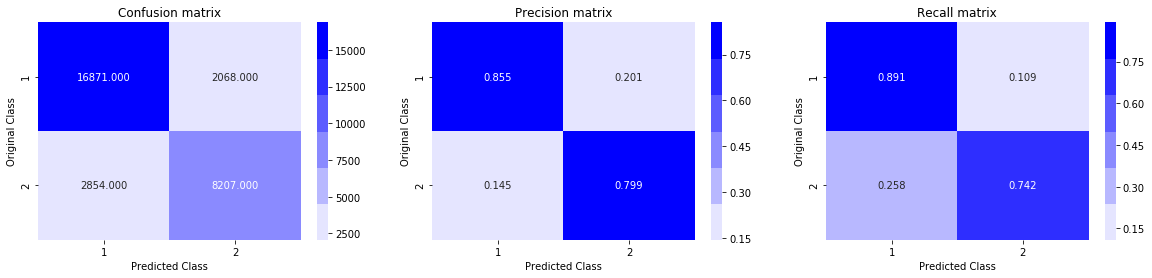

In [34]:
xgb_clf = XGBClassifier(objective='binary:logistic',
                        eval_metric = 'logloss',
                        alpha = best_alpha,
                        max_depth = best_depth,
                        n_estimators = best_estimators,
                        n_jobs = -1)

xgb_clf.fit(X_train, y_train)

sig_clf = CalibratedClassifierCV(xgb_clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', best_alpha, 'max_depth = ', best_depth ,' and n_estimators = ', best_estimators, "The train log loss is:",log_loss(y_train, predict_y, labels=xgb_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', best_alpha, 'max_depth = ', best_depth ,' and n_estimators = ', best_estimators, "The train log loss is:",log_loss(y_test, predict_y, labels=xgb_clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y, axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Conclusion

1. models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
    i. When used TF-IDF vectors, model predicted all test samples to be belong to class 1 as class 1 is majority class here.            which is not desired results.

2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.
   i. when used Xgboost with tuning of hyperparamater, it is giving the best log loss(0.34), precision and recall values among         all other models.